Martín Amado - 19020
Juan Pablo Pineda - 19087
### Hoja de trabajo 2

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.cm as cm
from factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from apyori import apriori
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
pd.set_option('display.max_rows', None)

## Analisis exploratorio

In [12]:
consumption = pd.read_excel('./CONSUMO-2022-05.xlsx', skiprows=6)
imports = pd.read_excel('./IMPORTACION-VOLUMEN-2022-05.xlsx', skiprows=6)

# Descripcion de los datos de interes

In [70]:
#TODO meter la fecha tambien
interes=['Gasolina superior', 'Gasolina regular', 'Diesel']
interesF=['Fecha', 'Gasolina superior', 'Gasolina regular', 'Diesel']
consumos = consumption[interesF]
#omitimos los datos despues del 269 ya que no aportan relevancia
consumos = consumos[:269]
importes = imports[interesF]
importes = importes[:257]

In [71]:
consumos.head(10)

,Fecha,Gasolina superior,Gasolina regular,Diesel
0,2000-01-01 00:00:00,308156.82,202645.2,634667.06
1,2000-02-01 00:00:00,307766.31,205530.96,642380.66
2,2000-03-01 00:00:00,331910.29,229499.56,699807.25
3,2000-04-01 00:00:00,315648.08,210680.4,586803.98
4,2000-05-01 00:00:00,319667.97,208164.34,656948.2
5,2000-06-01 00:00:00,300347.7,195088.74,570919.88
6,2000-07-01 00:00:00,308305.93,204556.77,576436.02
7,2000-08-01 00:00:00,323011.86,218388.51,593770.77
8,2000-09-01 00:00:00,326455.72,213906.96,590145.4
9,2000-10-01 00:00:00,323843.63,213606.65,641113.36


In [72]:
importes.head(10)

,Fecha,Gasolina superior,Gasolina regular,Diesel
0,2001-01-01,373963.96,177776.5,566101.99
1,2001-02-01,243091.07,123115.99,489525.8
2,2001-03-01,312084.38,161726.42,575559.68
3,2001-04-01,285054.89,127338.74,437745.42
4,2001-05-01,300913.67,168730.19,552609.13
5,2001-06-01,333217.19,152899.09,497855.26
6,2001-07-01,195071.86,136299.13,302350.02
7,2001-08-01,268153.26,139365.07,464159.13
8,2001-09-01,308439.07,233643.75,321952.94
9,2001-10-01,305102.28,141550.22,438989.55


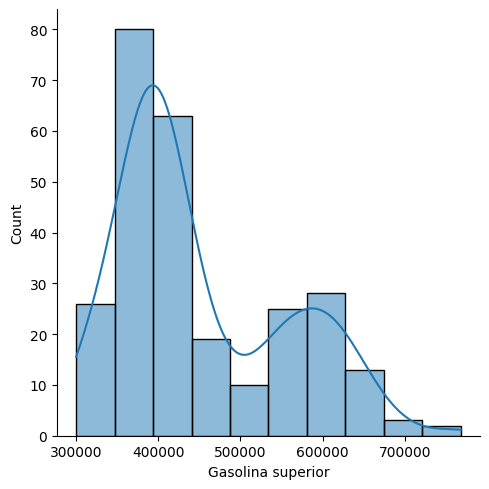

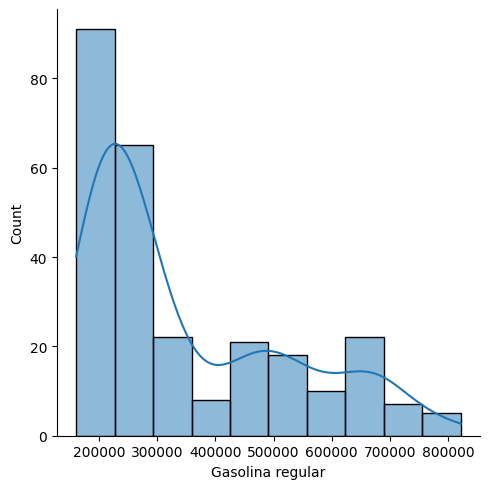

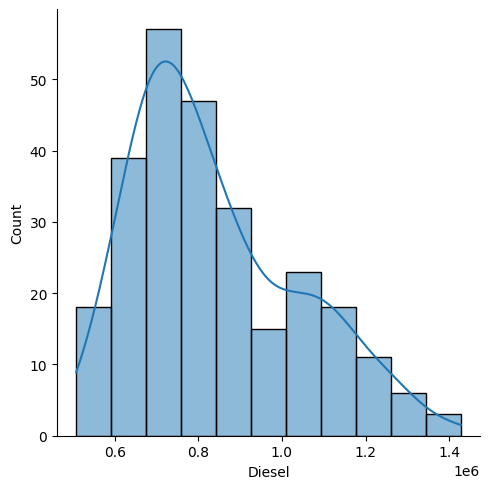

In [74]:
for var in interes:
    sns.displot(consumos[var], kde=True)

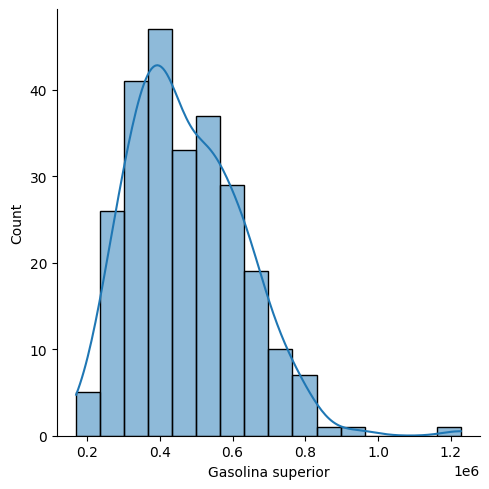

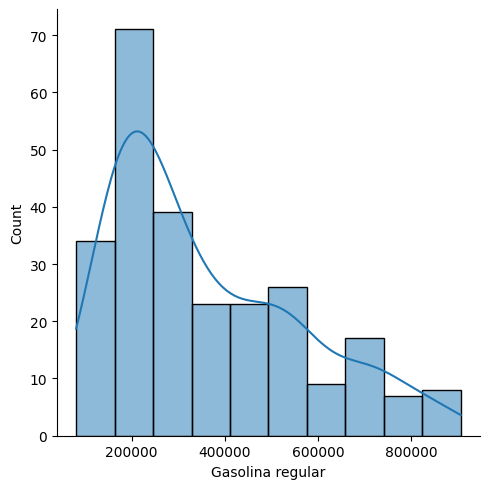

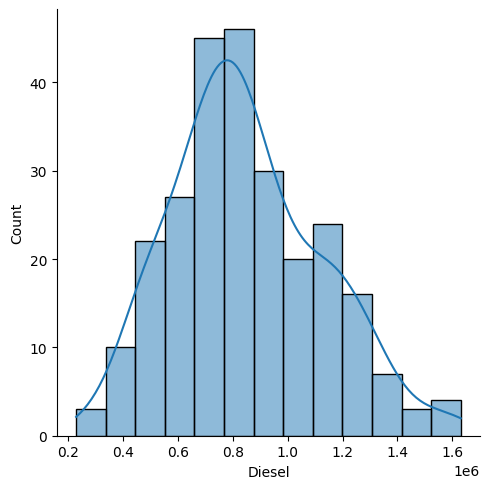

In [75]:
for var in interes:
    sns.displot(importes[var], kde=True)

In [91]:
fechaConsumo = [pd.to_datetime(d) for d in consumos['Fecha']]
consumos['Fecha'] = fechaConsumo
fechaImportes = [pd.to_datetime(d) for d in importes['Fecha']]
importes['Fecha'] = fechaImportes

Separamos los datos en fechas 

In [86]:
fechasC = pd.DataFrame()
fechasC['consumptionDate'] = fechaConsumo
fechasC['year'] = fechasC['consumptionDate'].dt.year
fechasC['month'] = fechasC['consumptionDate'].dt.month


fechasI = pd.DataFrame()
fechasI['consumptionDate'] = fechaImportes
fechasI['year'] = fechasI['consumptionDate'].dt.year
fechasI['month'] = fechasI['consumptionDate'].dt.month


# Pico de consumo por mes

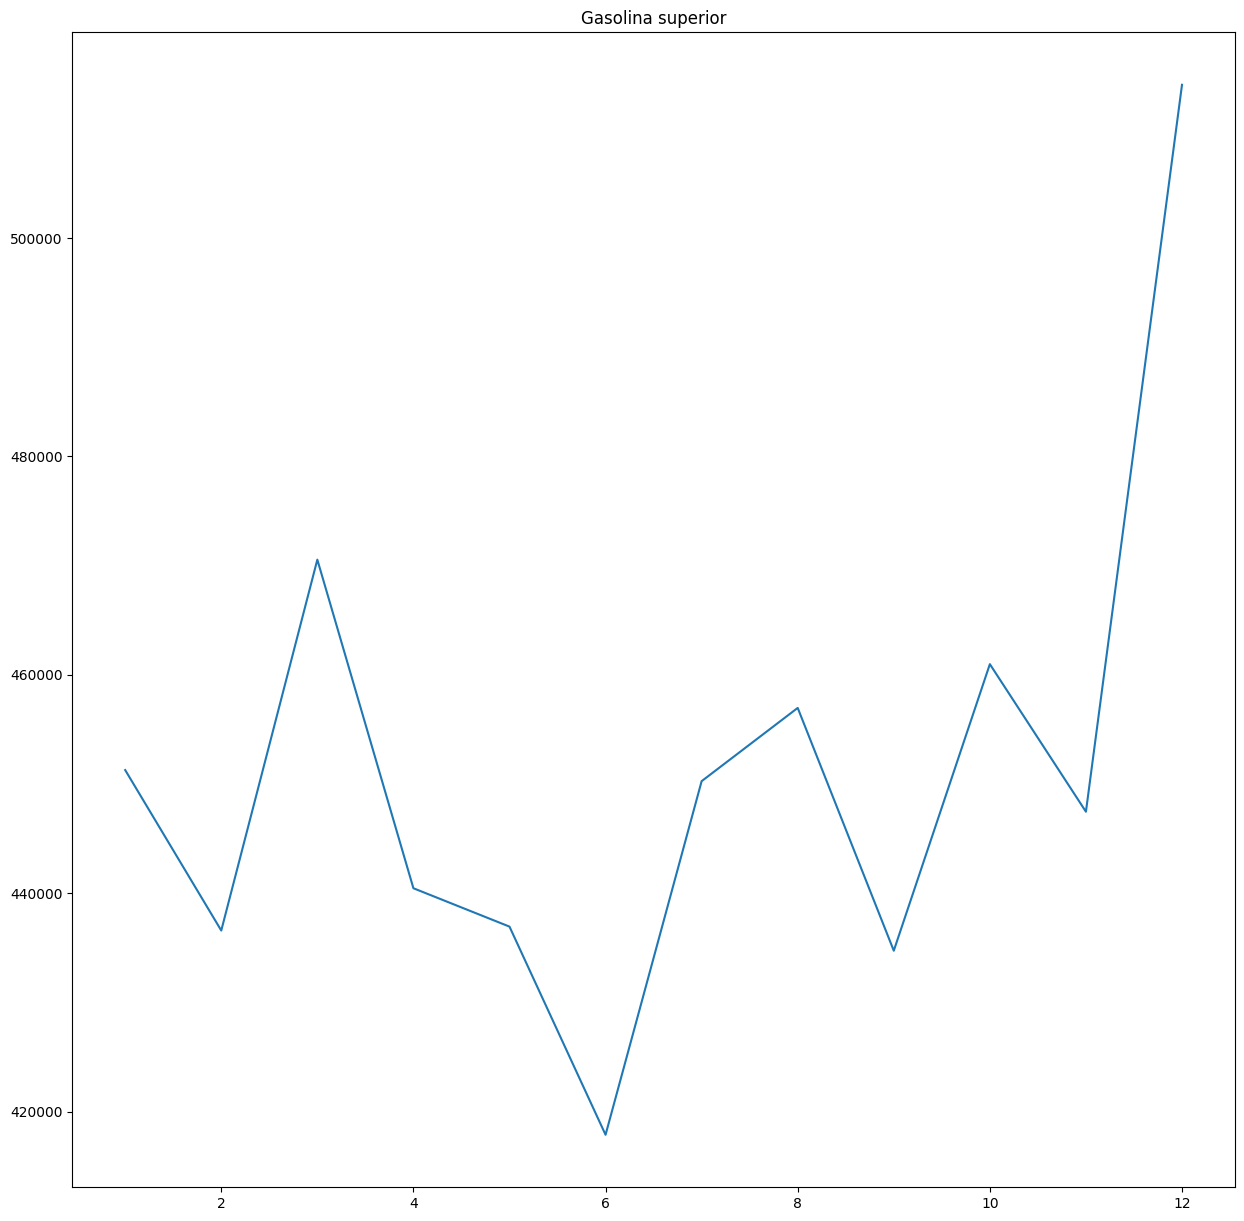

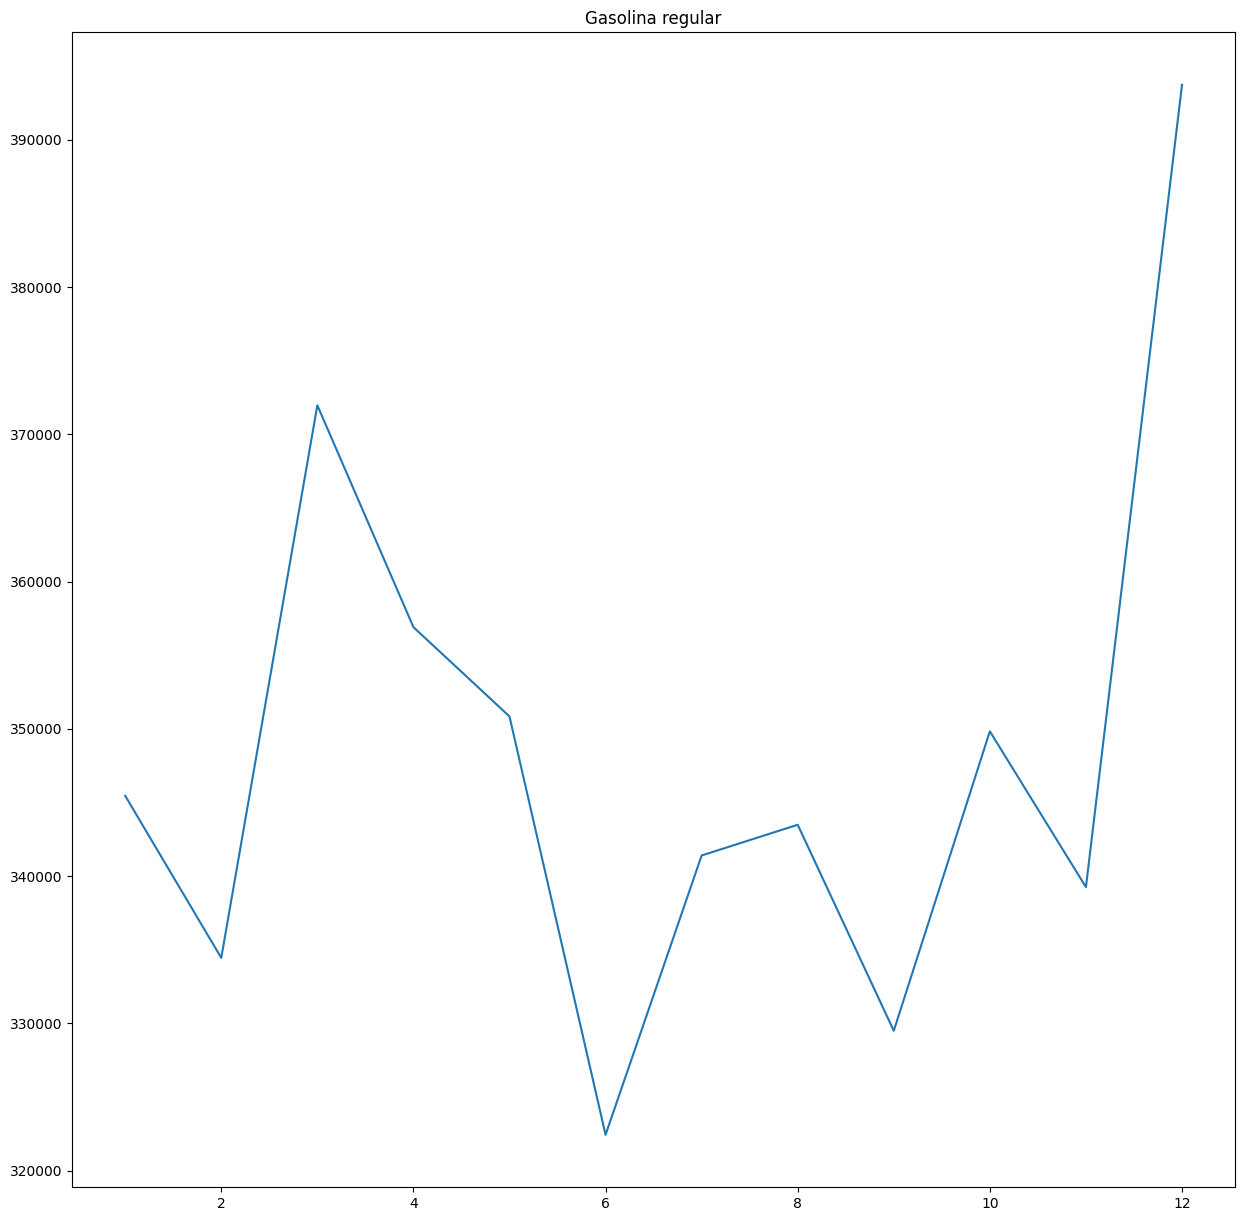

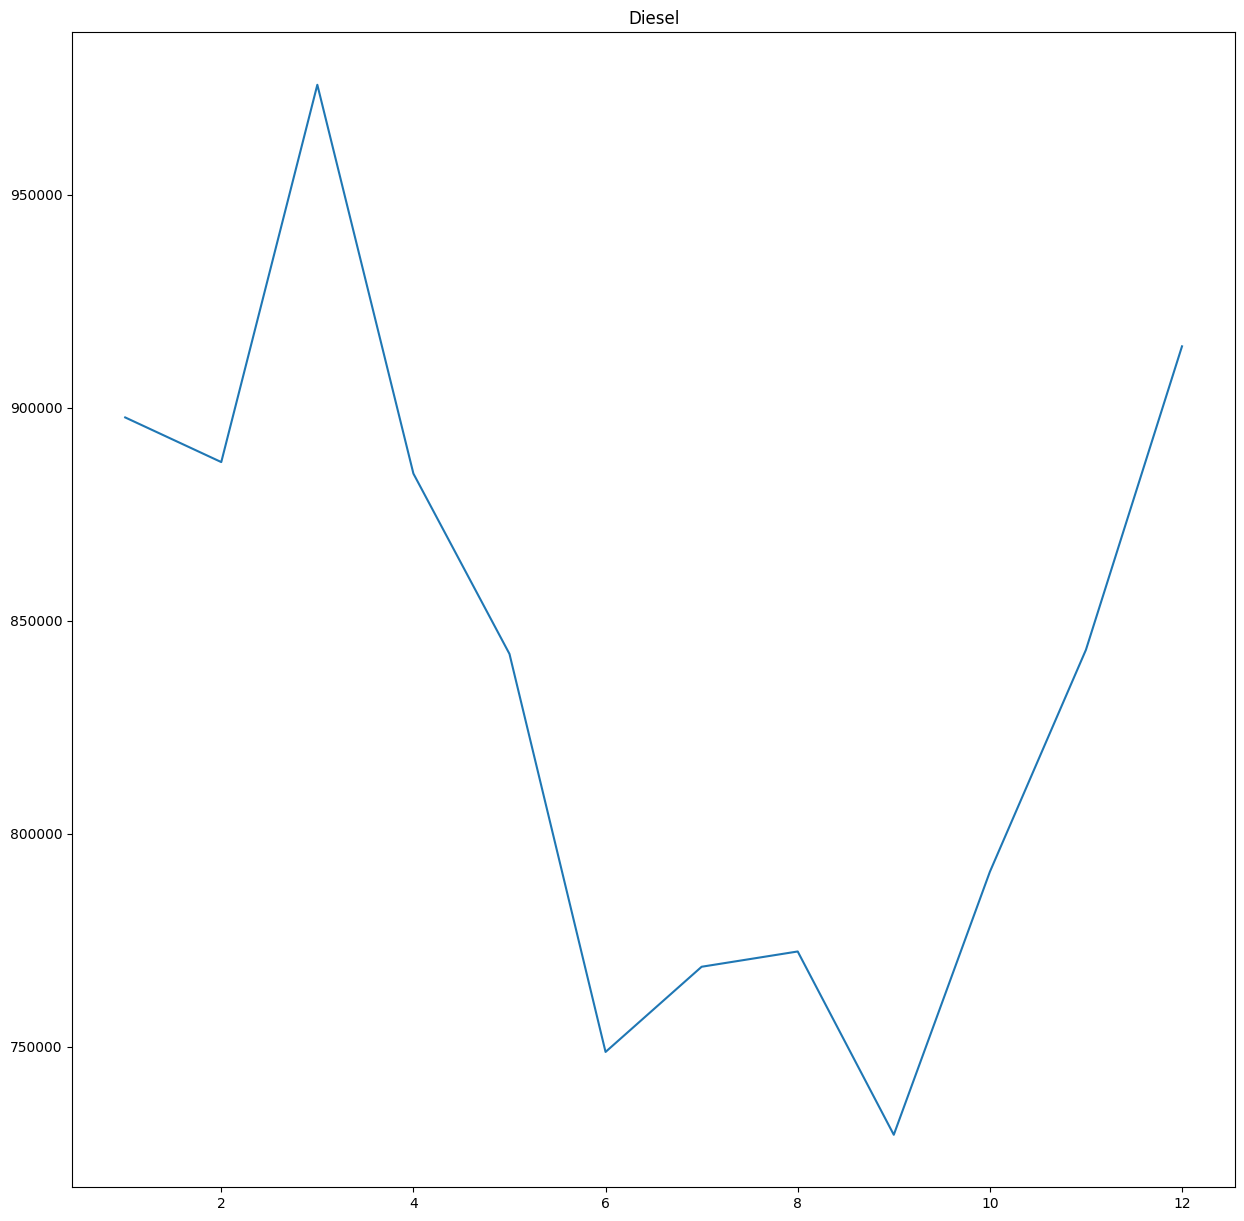

In [98]:
monthlyData = consumos.groupby(consumos['Fecha'].dt.month)
months = []
for name, group in monthlyData:
    months.append(name)

for x in interes:
    figure = plt.figure()
    figure.set_figwidth(15)
    figure.set_figheight(15)
    plt.title(x)
    plt.plot(months, monthlyData.mean()[x])
    plt.show()
    


# Pico de importaciones por mes

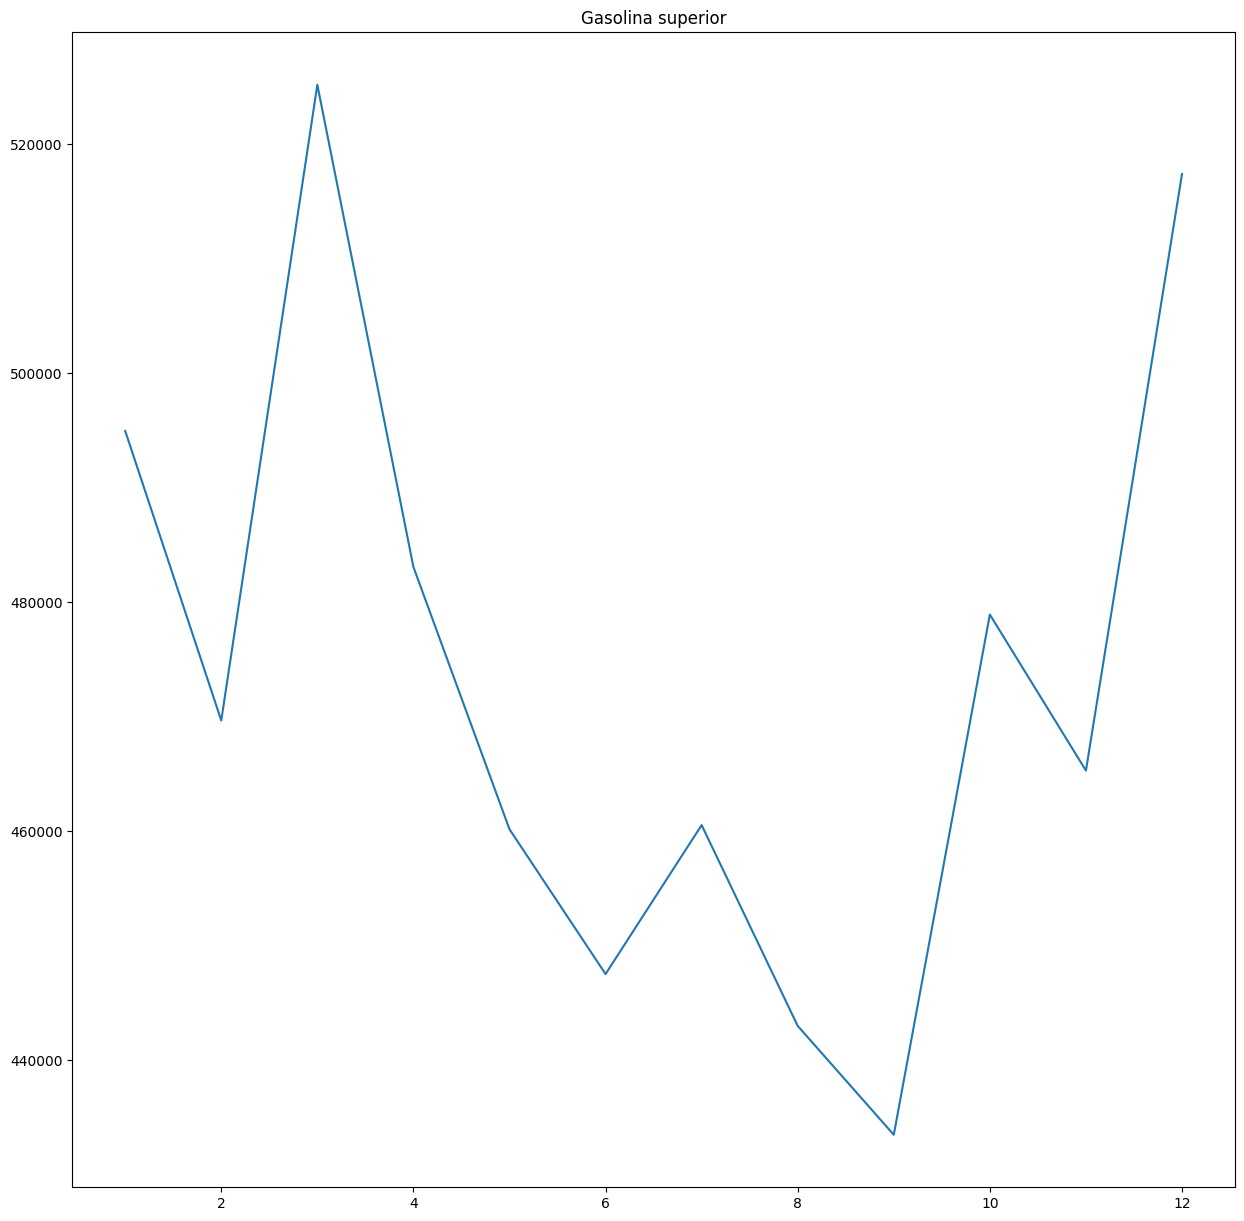

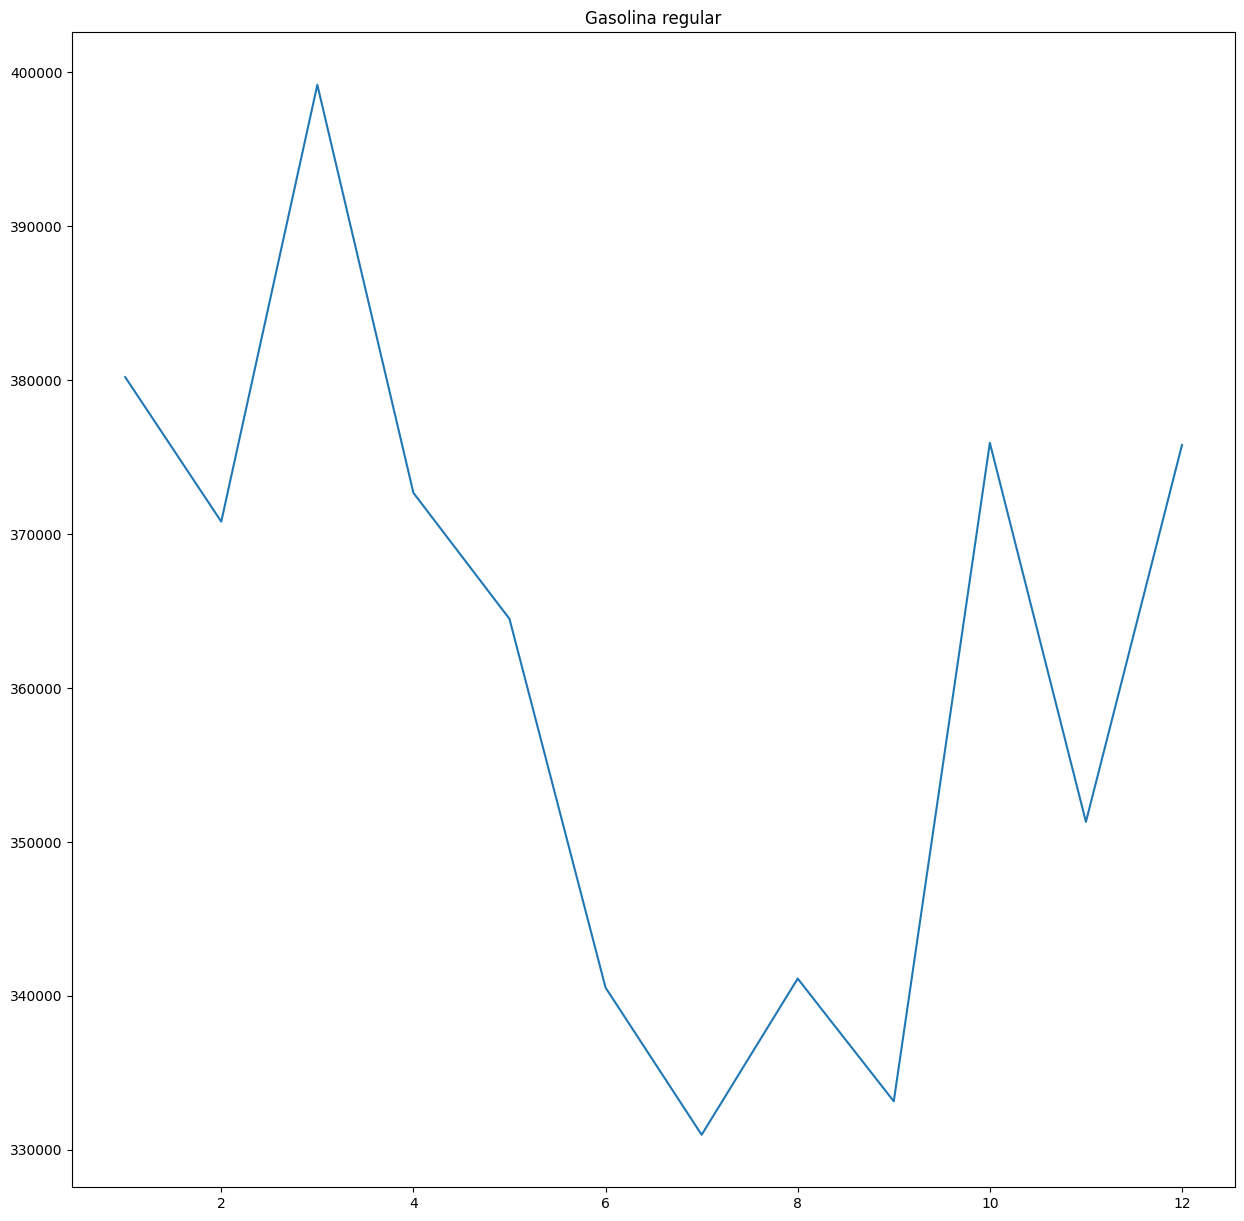

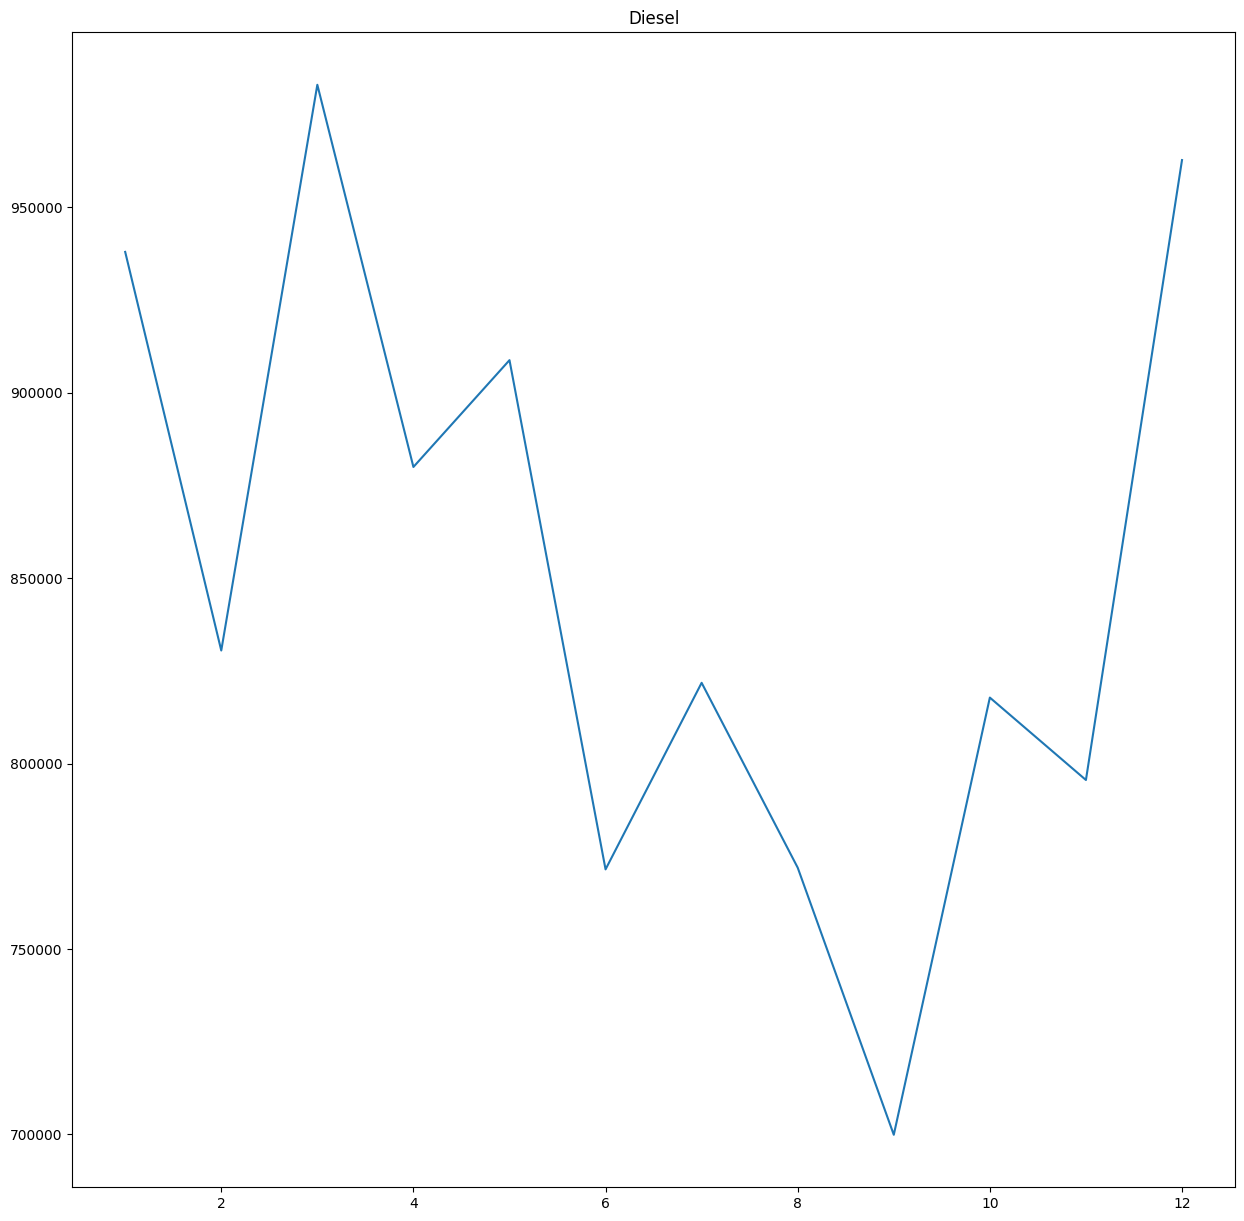

In [100]:
monthlyData = importes.groupby(importes['Fecha'].dt.month)
months = []
for name, group in monthlyData:
    months.append(name)

for x in interes:
    figure = plt.figure()
    figure.set_figwidth(15)
    figure.set_figheight(15)
    plt.title(x)
    plt.plot(months, monthlyData.mean()[x])
    plt.show()
    


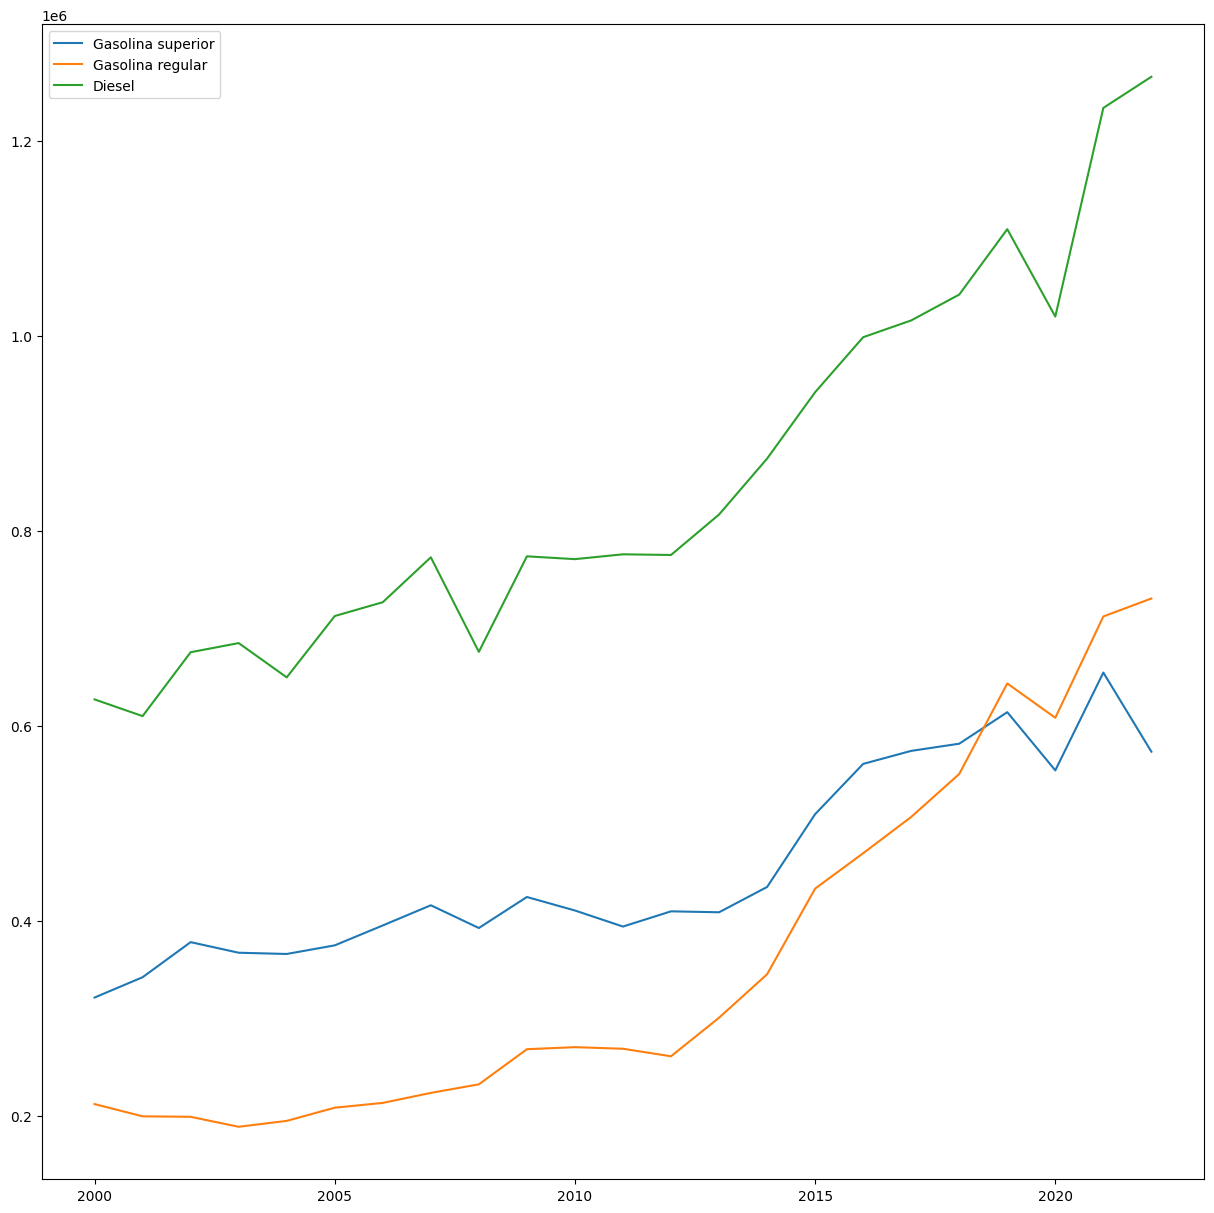

In [105]:
yearData = consumos.groupby(consumos['Fecha'].dt.year)
years = []
for name, group in yearData:
    years.append(name)

figure = plt.figure()
figure.set_figwidth(15)
figure.set_figheight(15)
for x in interes:
    plt.plot(years, yearData.mean()[x], label=x)

plt.title('Consumos por año por tipo de gasolina')
plt.legend()
plt.show()


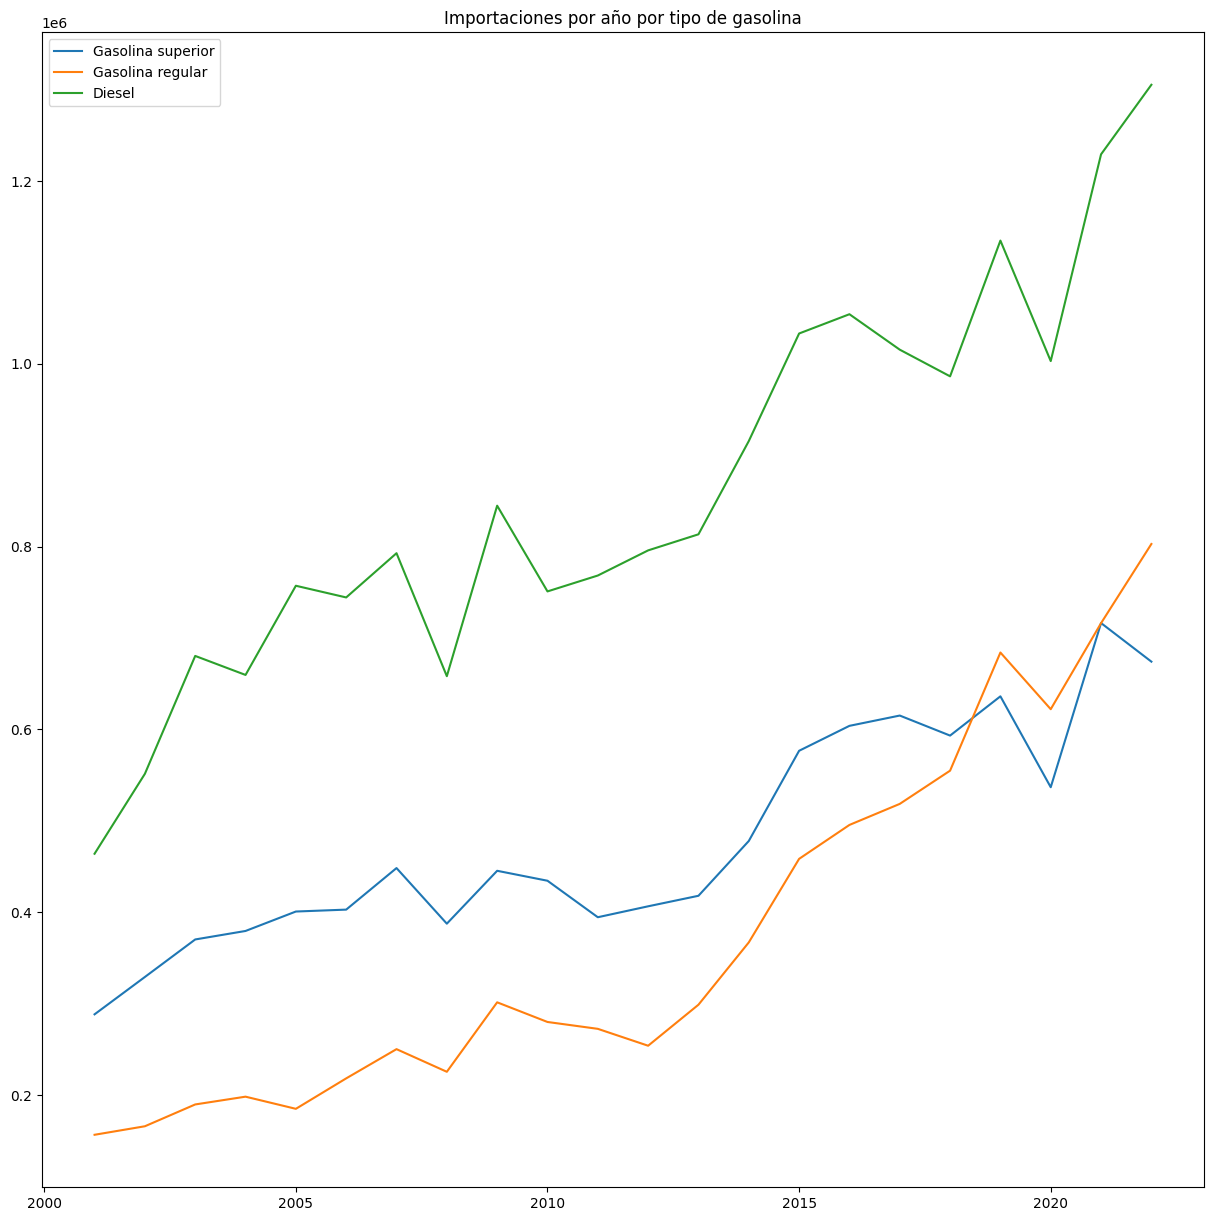

In [106]:
yearData = importes.groupby(importes['Fecha'].dt.year)
years = []
for name, group in yearData:
    years.append(name)

figure = plt.figure()
figure.set_figwidth(15)
figure.set_figheight(15)
for x in interes:
    plt.plot(years, yearData.mean()[x], label=x)

plt.title('Importaciones por año por tipo de gasolina')
plt.legend()
plt.show()


# Comportamiento de importaciones en 2020

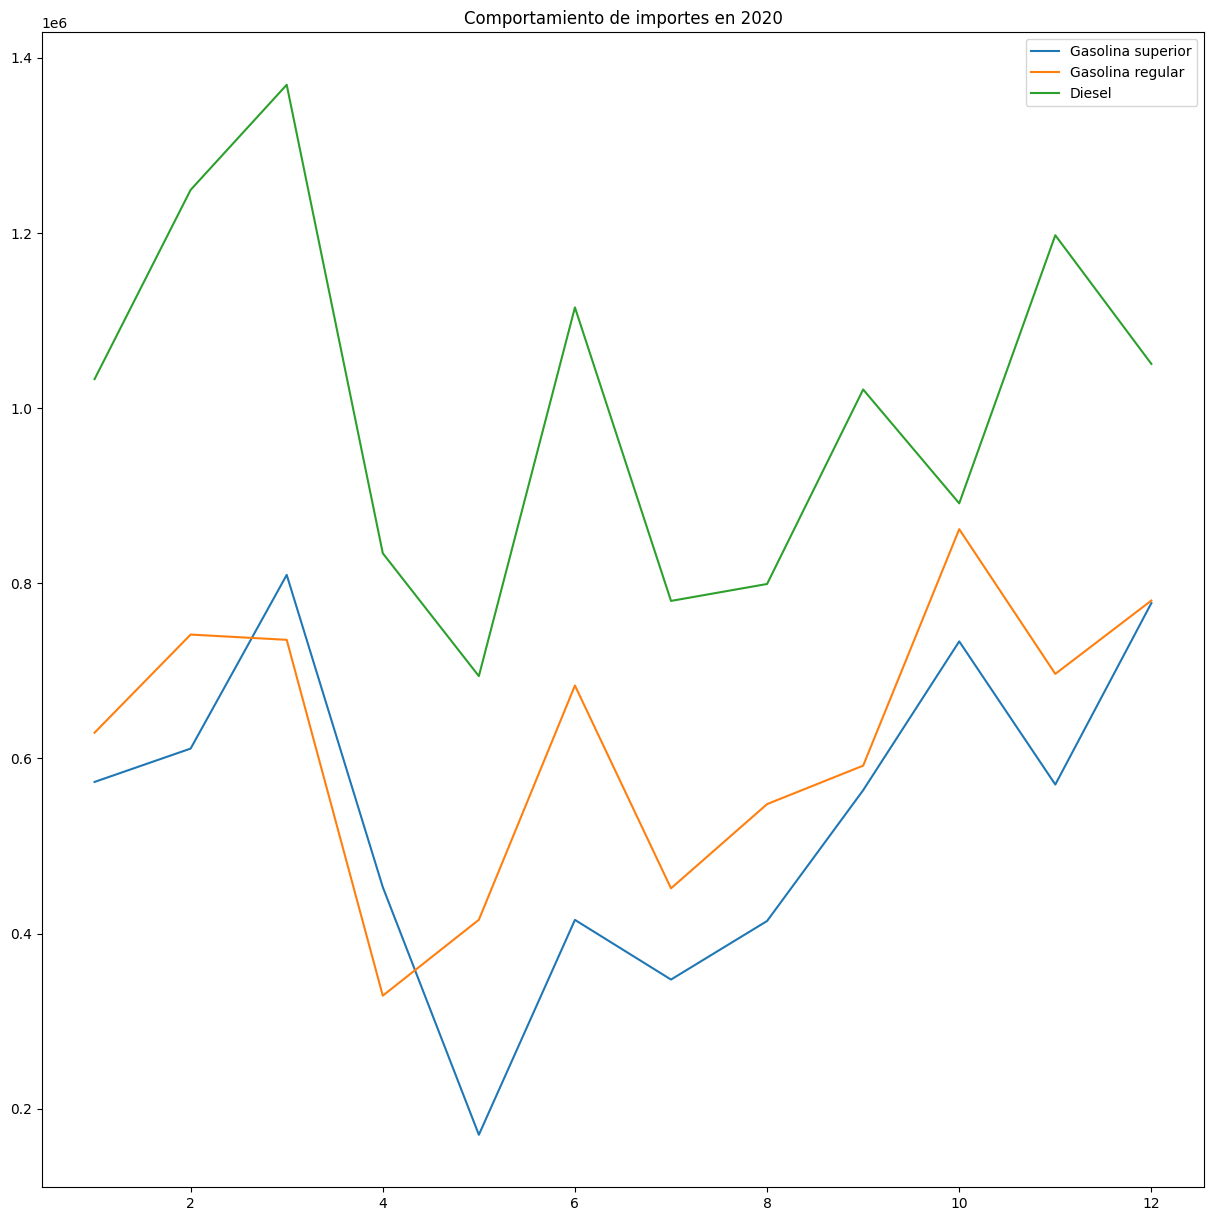

In [108]:
monthlyData = importes.where(importes['Fecha'].dt.year == 2020).groupby(importes['Fecha'].dt.month)
months = []
for name, group in monthlyData:
    months.append(name)

figure = plt.figure()
figure.set_figwidth(15)
figure.set_figheight(15)
for x in interes:
    plt.plot(months, monthlyData.mean()[x], label=x)

plt.title('Comportamiento de importaciones en 2020')
plt.legend()    
plt.show()

# Comportamiento de consumos en 2020

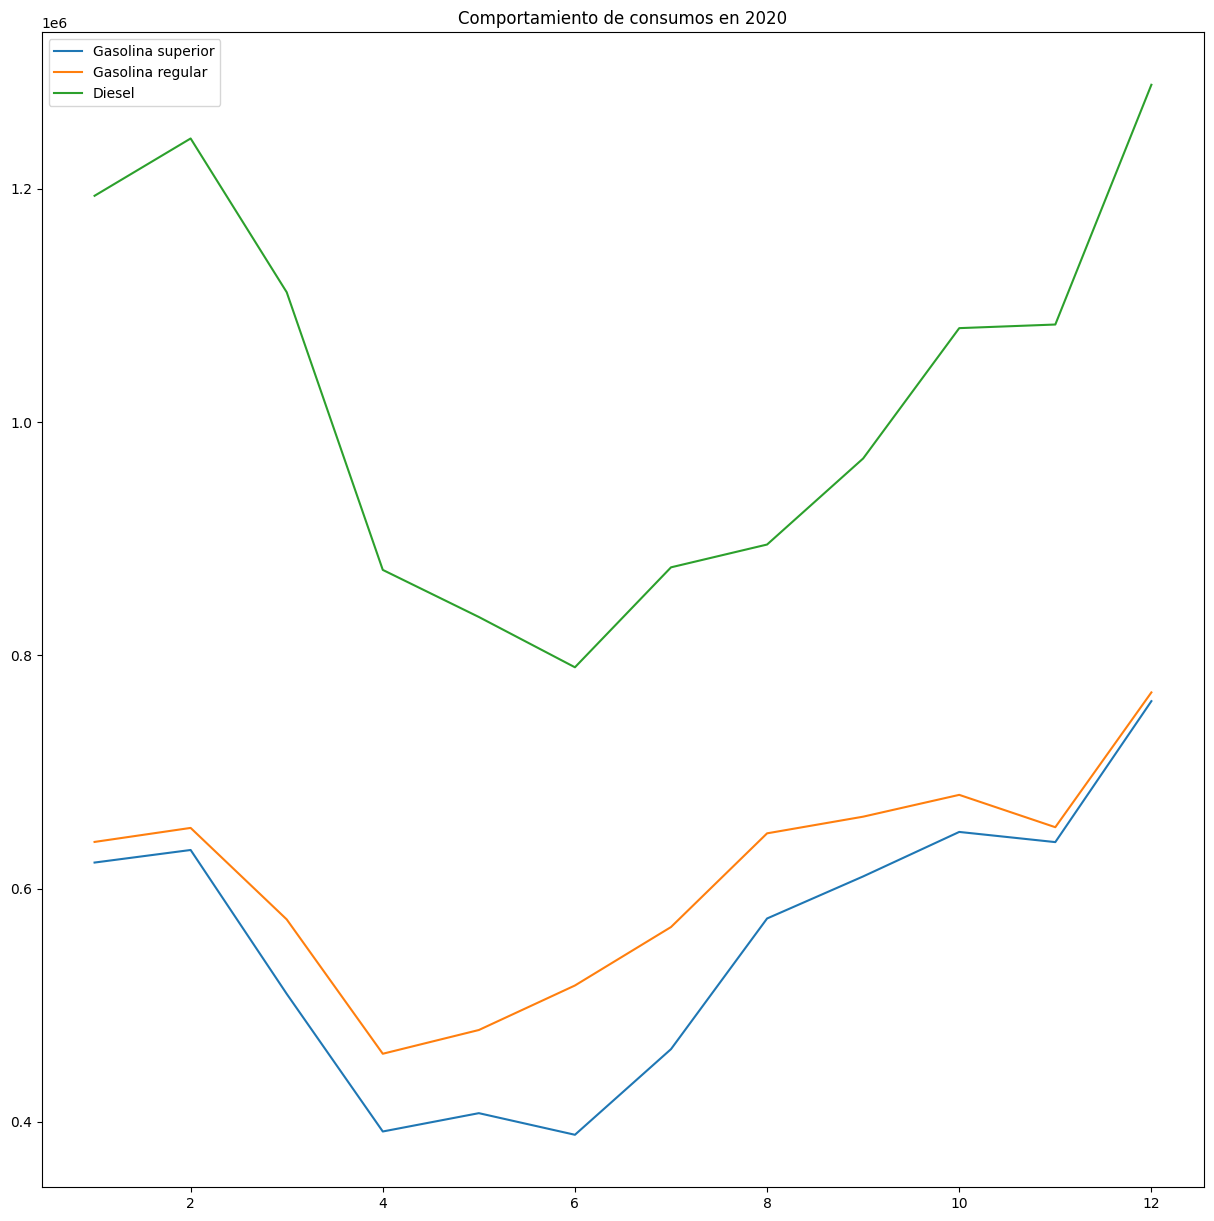

In [109]:
monthlyData = consumos.where(consumos['Fecha'].dt.year == 2020).groupby(consumos['Fecha'].dt.month)
months = []
for name, group in monthlyData:
    months.append(name)

figure = plt.figure()
figure.set_figwidth(15)
figure.set_figheight(15)
for x in interes:
    plt.plot(months, monthlyData.mean()[x], label=x)

plt.title('Comportamiento de consumos en 2020')
plt.legend()    
plt.show()

### Serie de tiempo

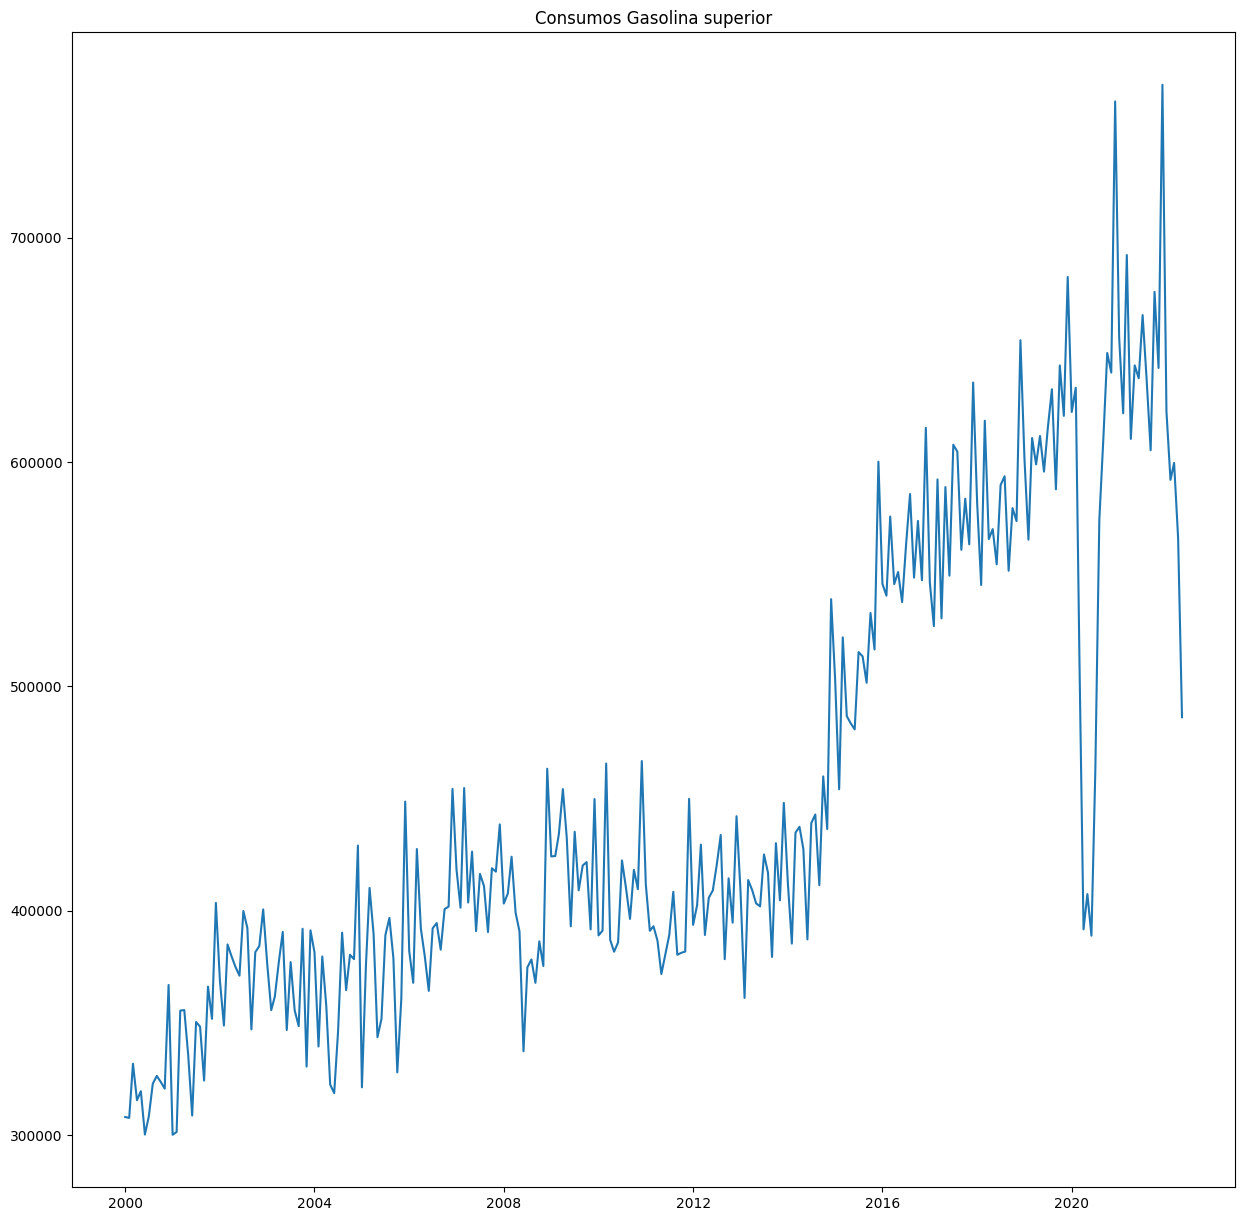

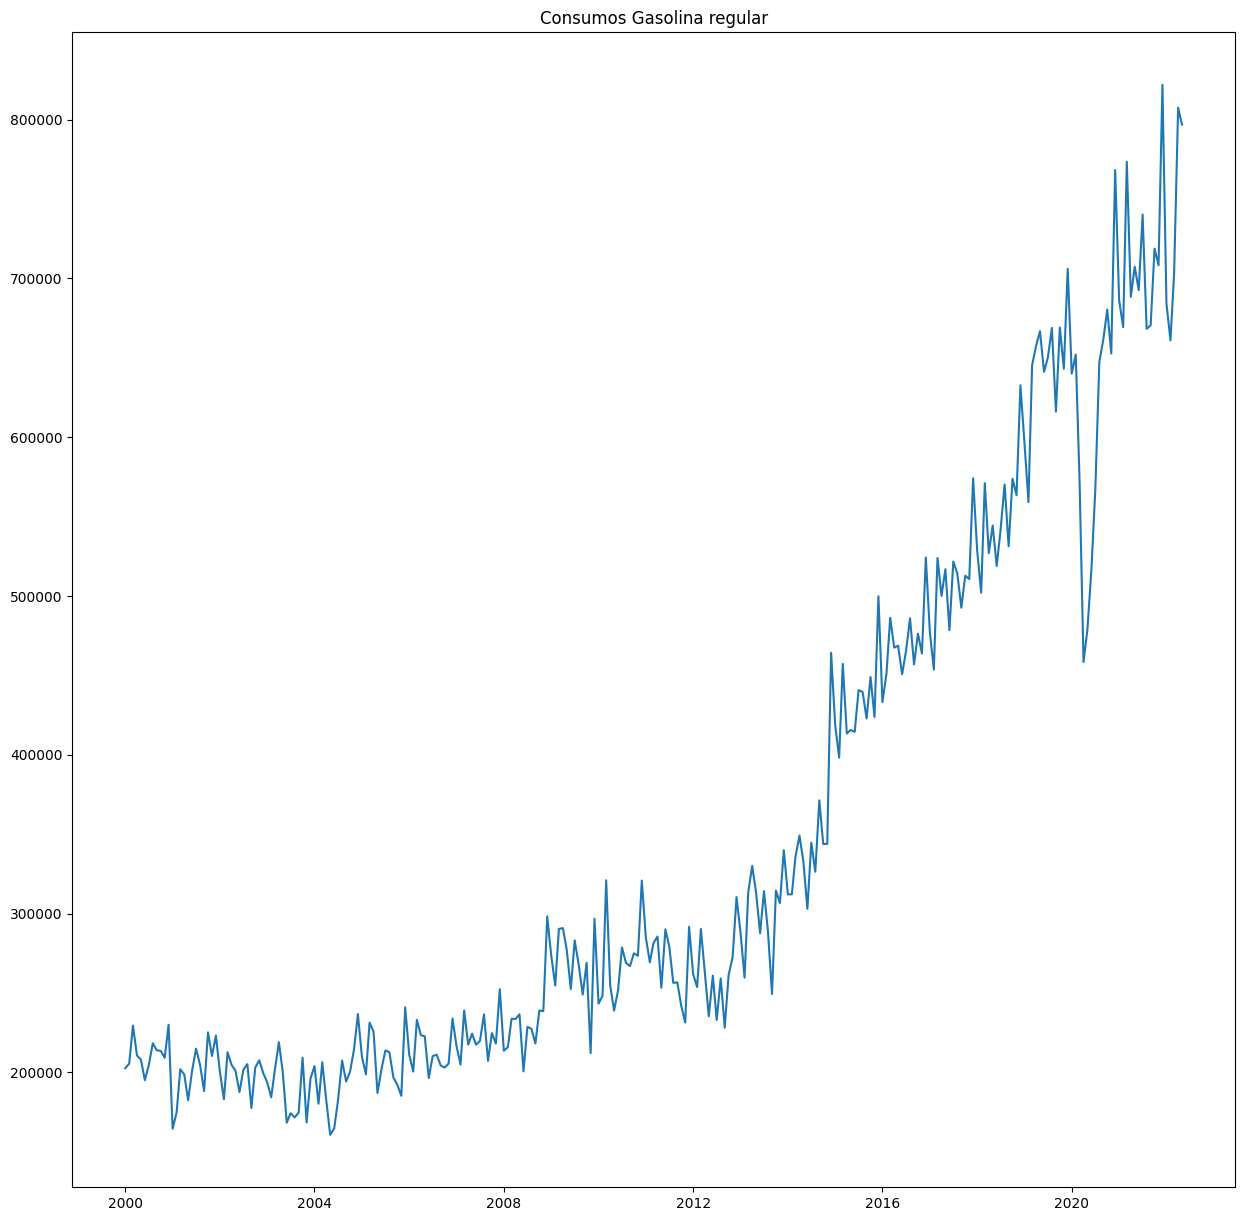

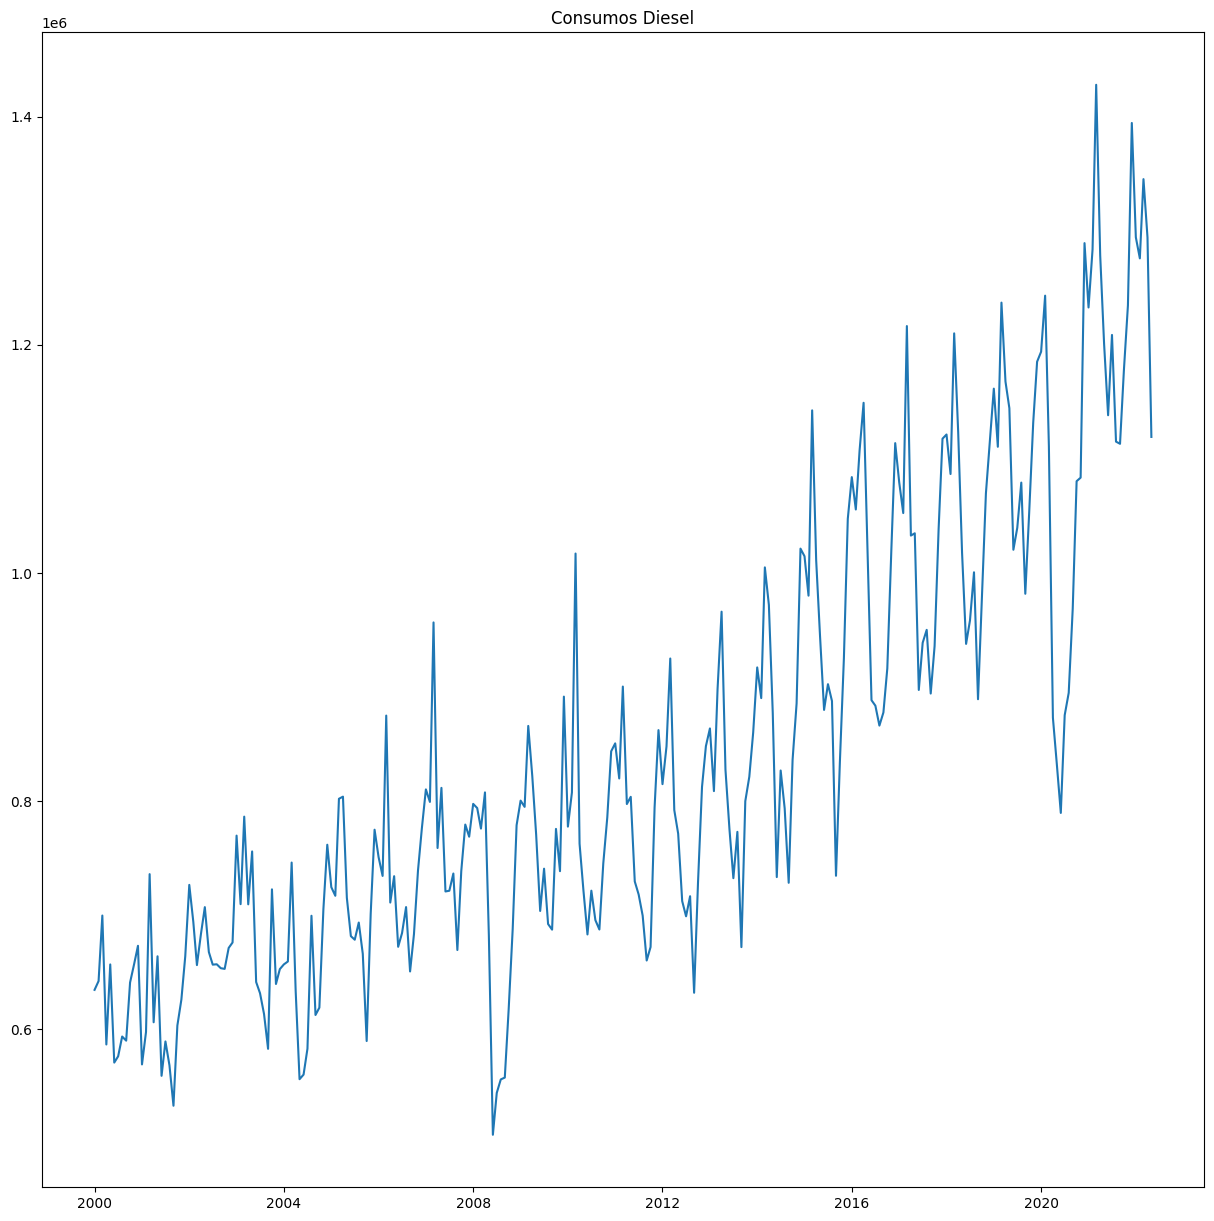

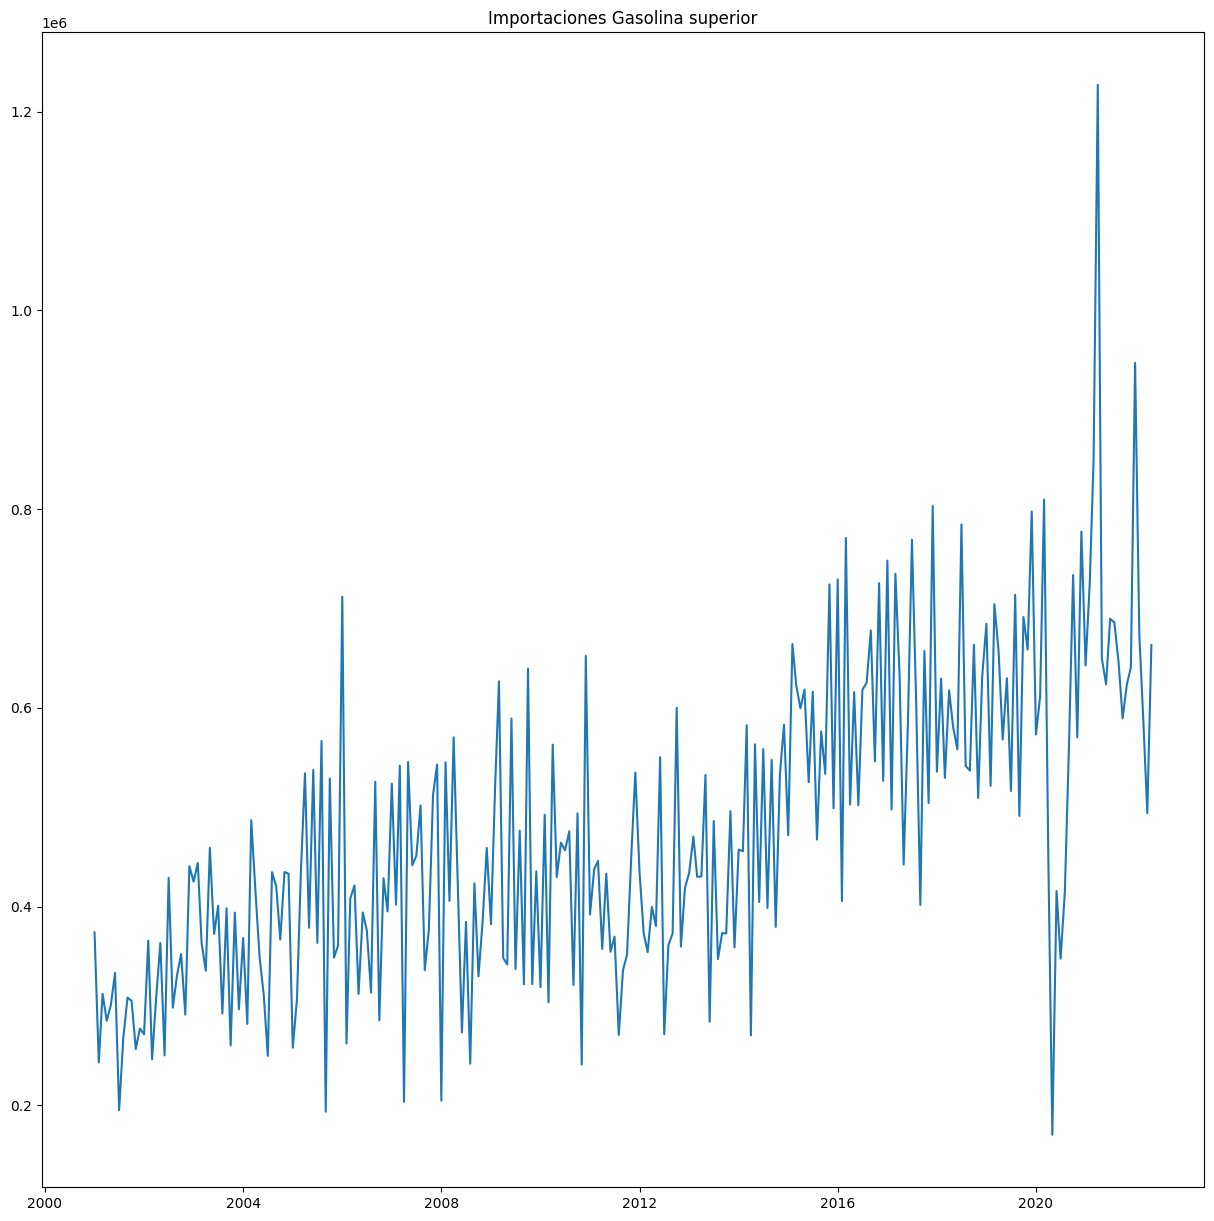

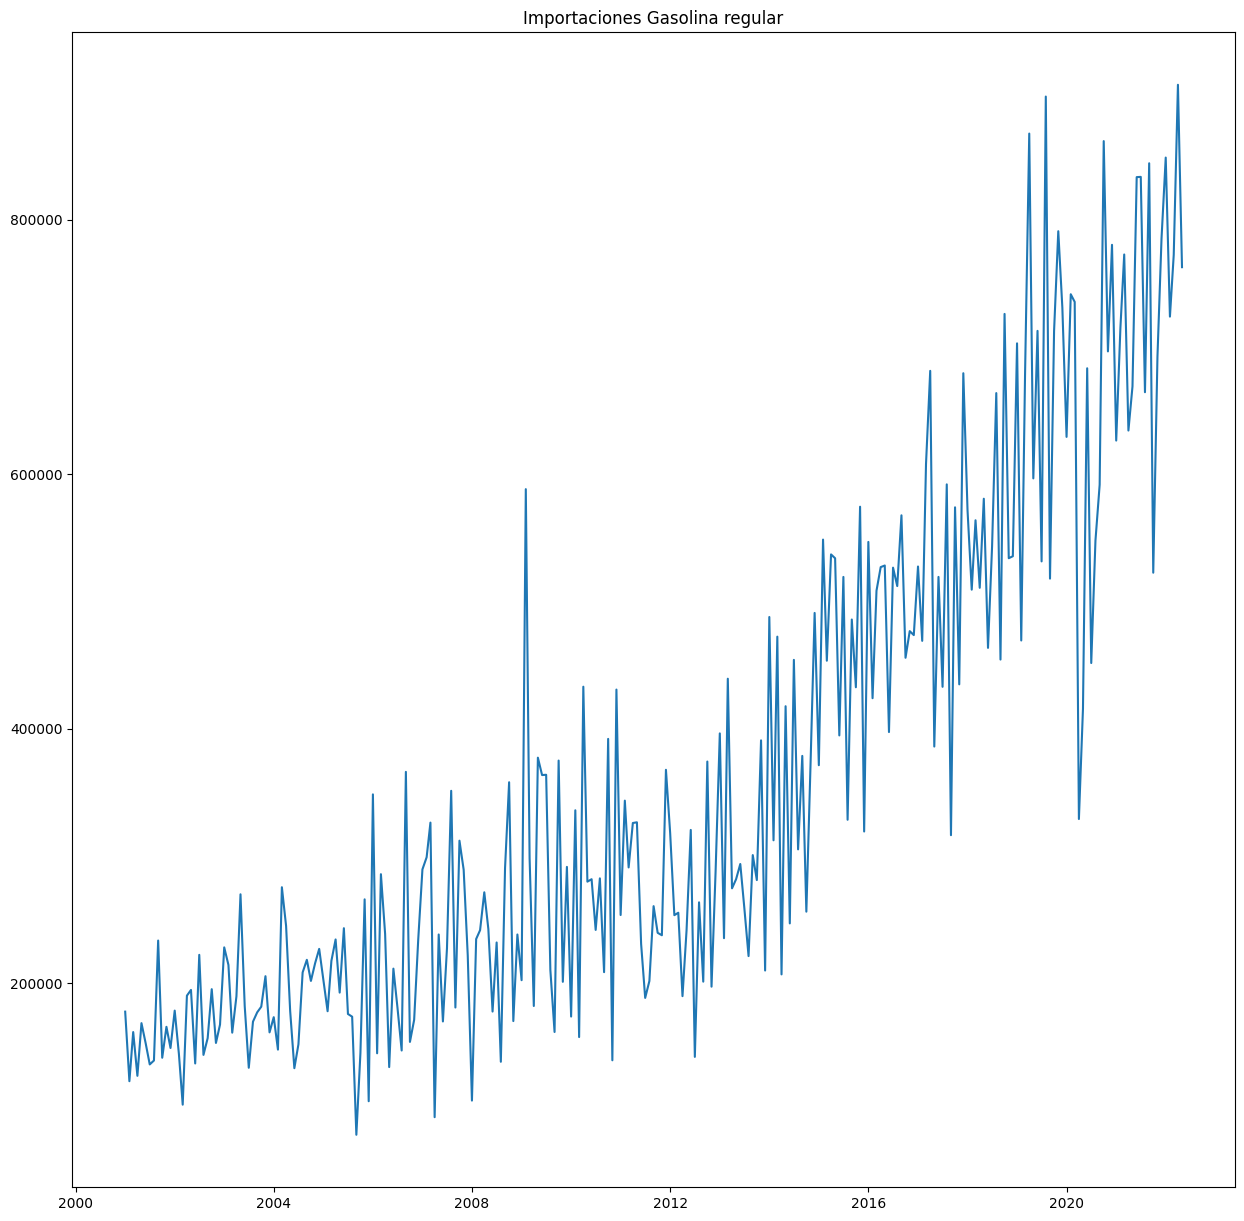

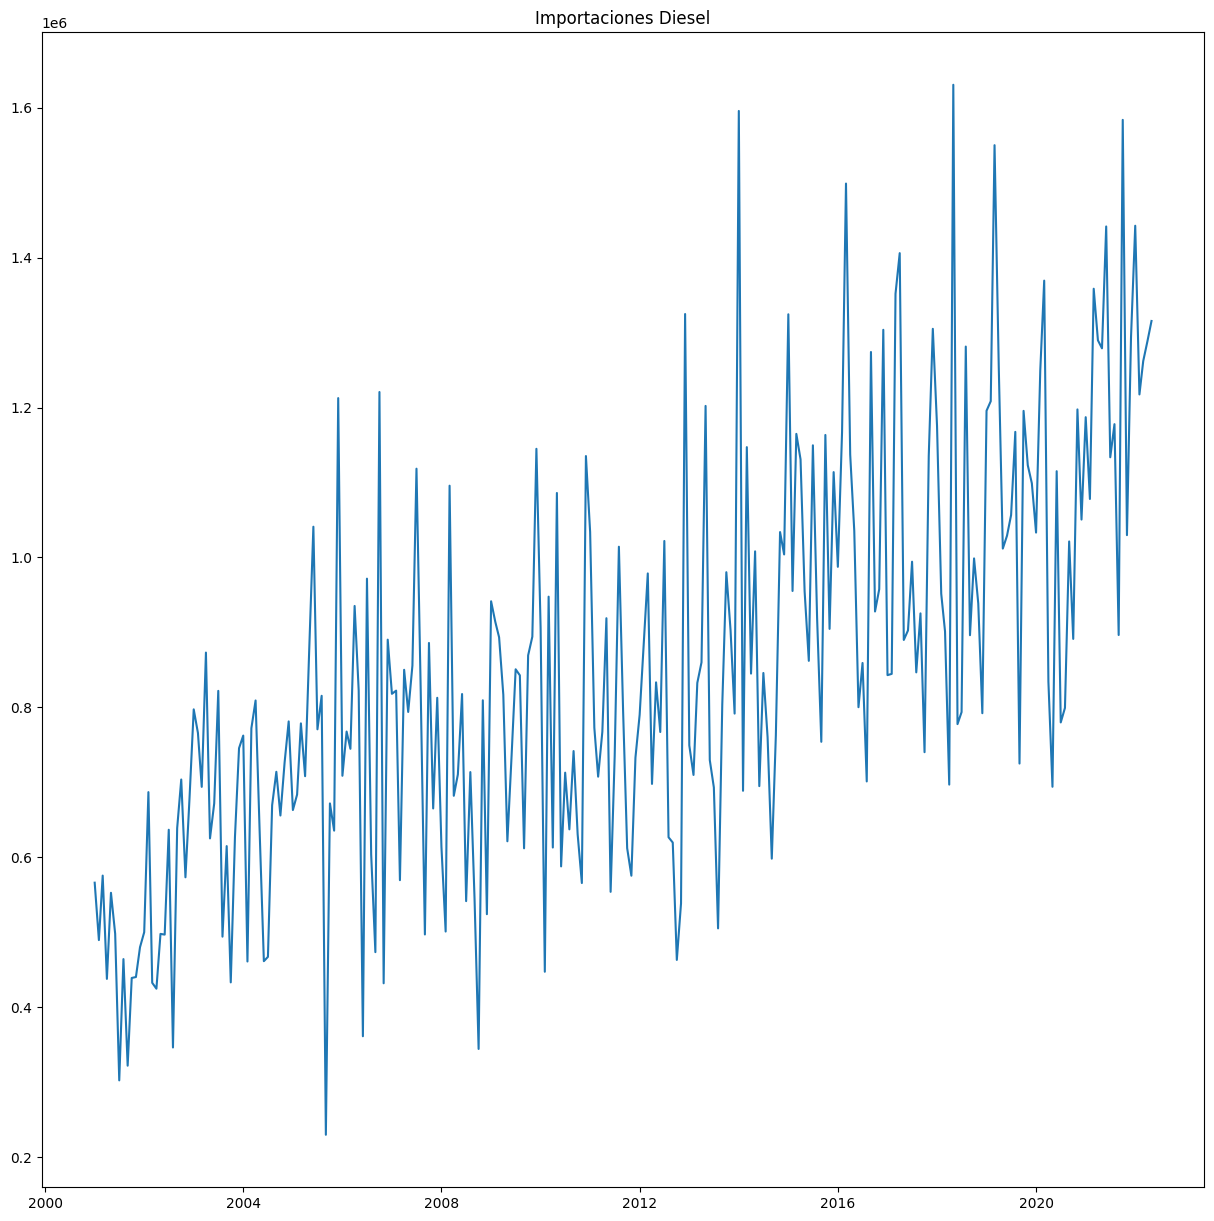

In [122]:
for x in interes:
    figure = plt.figure()
    figure.set_figwidth(15)
    figure.set_figheight(15)
    plt.plot(consumos['Fecha'], consumos[x], label="consumos")
    plt.title(f'Consumos {x}')
    plt.show()

for x in interes:
    figure = plt.figure()
    figure.set_figwidth(15)
    figure.set_figheight(15)
    plt.plot(importes['Fecha'], importes[x], label="Importaciones")
    plt.title(f'Importaciones {x}')
    plt.show()